# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Luis Saez Diaz
+ Erwin Nuñez Bracho

**Correos Electrónicos:**

+ lu.saezd@duocuc.cl
+ er.nunez@duocuc.cl

**Fecha de Creación:** 07 de Abril de 2025  
**Versión:** 0.5  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python, keras y tensorflow para el manejo de las redes neuronales y el matplotlib para la creacion de graficos con python.

# Carga de datos

In [ ]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-19 21:49:15--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  6.26MB/s    in 1.5s    

2025-04-19 21:49:18 (6.26 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-19 21:49:18--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 64.233.189.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [applica

In [ ]:
!ls -lh

total 45M
-rw-r--r-- 1 root root 6.7M Apr 19 20:55 adamax_base.h5
-rw-r--r-- 1 root root 6.7M Apr 19 20:58 adamax_exp1.h5
-rw-r--r-- 1 root root 6.7M Apr 19 21:03 adamax_exp2.h5
-rw-r--r-- 1 root root 6.7M Apr 19 21:07 adamax_exp3.h5
-rw-r--r-- 1 root root 6.7M Apr 19 20:39 nadam_exp5.h5
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [ ]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical
from keras.models import Sequential

# Carga de imágenes

In [ ]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


La cantidad de datos en la muestra de entrenamiento es de 60.000 datos,
al vectorizarlos (aplanar) nos queda que las imagenes representan 784 pixeles vectorizados. En el caso de nuestra muestra de evaluación tenemos 10.000
con la misma cantidad de pixeles vectorizados y en el caso de las etiquetas tenemos que son 10.

Posteriormente a la carga los datos son normalizados, re-ajustando sus valores en valores de 0 a 255 lo que permite que todos mantengan un mismo rango de valores (formato) y no hayas valores que se disparen a diferencia de los demas.

# Muestra imágenes

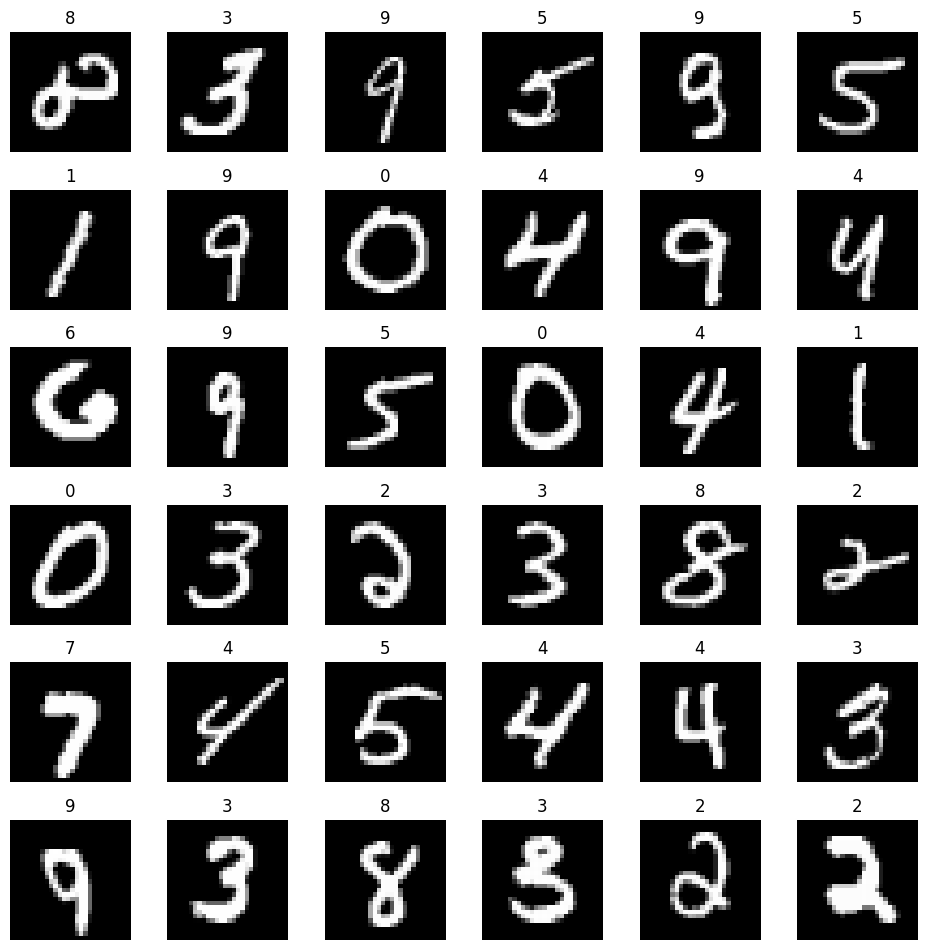

In [ ]:
h, w = 6, 6  # tamaño de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h, 1.6*w))

for i in range(h):
    for j in range(w):
        idx = np.random.randint(len(X_train))  # índice aleatorio
        img = X_train[idx].reshape(28, 28)  # redimensionar imagen
        label = np.argmax(y_train[idx])     # obtener etiqueta

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(str(label))
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Hacemos una muestra aleatoria de los datos y sus etiquetas de nuestro set de datos de entrenamiento donde podemos ver que es un set de datos que contiene imagenes en blanco y negro de numeros del 0 al 9.

# Red neuronal 1: Optimizador Adamax

## Red base

Para esta fase de experimentación, siendo que nuestros datos no tienen una gran dispersion ya que trabajan unicamente con 2 colores, se tomo la decision de utilizar los optimizadores de Adamax y Nadam, adamax siendo la mejora del optimizador adam que suele tener buen rendimiento en la mayoria de los casos y Nadam siendo el optimizador adam pero agregandole momentum. Esto nos permitira saber como se comporta nuestra red neuronal con un optimizador que posea momentum y nos permita optimizar los tiempos en los que ajusta los pesos.

en el caso de la funcion de perdida utilizaremos **categorical crossentropy** ya que es la que se comporta mejor con datos que esten en formato one hot enconding, en este caso nuestras clases estan formateadas de esa forma.

In [ ]:
np.random.seed(29)
tf.random.set_seed(29)

history = {} # creamos el historial para guardar los resultados de los modelos

input_shape = X_train.shape[1]
labels_output = y_train.shape[1]
print(input_shape)
print(y_train.shape[1])

# estructura de layers: [512, 256, 128, 64]
def create_model(name:str, input:int, output:int, layers:np.ndarray, optimizer:str, activation:str = 'relu', dropout:np.ndarray = np.array([0, 0])):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Input(shape=(input,), name="input_layer"))

  dropout_count = 0

  for i in range(len(layers)):
    model.add(keras.layers.Dense(layers[i], activation=activation, name=f'hide_layer{i+1}'))

    if(dropout[0] > 0 and dropout_count != dropout[0]):
      model.add(keras.layers.Dropout(dropout[1]))
      dropout_count+=1
  model.add(keras.layers.Dense(output, activation="softmax", name="output_layer"))

  model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
  )

  return model


def train_model(history, model:Sequential, X_train, y_train, X_test, y_test, epochs:int = 10, batch_size:int = 10):

  result = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
  history[model.name] = { 'result': result }

  return history

784
10


Evaluamos cuantas neuronas tendra la capa de entrada (784) y la capa de salida (10) correspondiente a la cantidad de datos que entraran y la cantidad de clases con las que debera responder la red neuronal. Ademas se setean semillas randoms para tensorflow y numpy para asegurar la aleatoriedad.

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("adamax_base", input_shape, labels_output, layers, "adamax")

En este caso se tomo la decision de utilizar unicamente la precisión (accuracy) ya que es la metrica mas relevente para la problematica presentada. El f1-score solo nos sera util si hay presente desbalance de clase y este no es el caso (informacion entregada por el negocio - docente).

La precision y el recall, su interpretacion, habla sobre clase positiva y clase negativa haciendo alucion a un modelo de prediccion binario, es decir que solo tiene 2 clases. En este caso nuestro modelo es multi-clase por lo que estas metricas pierden total relevancia dado el enfoque de nuestro modelo.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - accuracy: 0.8927 - loss: 0.3629 - val_accuracy: 0.9635 - val_loss: 0.1235
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9721 - loss: 0.0944 - val_accuracy: 0.9709 - val_loss: 0.0969
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step - accuracy: 0.9830 - loss: 0.0573 - val_accuracy: 0.9687 - val_loss: 0.1049
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.9892 - loss: 0.0376 - val_accuracy: 0.9711 - val_loss: 0.0998
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9932 - loss: 0.0248 - val_accuracy: 0.9732 - val_loss: 0.0999
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9955 - loss: 0.0167 - val_accuracy: 0.9759 - val_loss: 0.0948
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.9971 - loss: 0.0120 - val_accuracy: 0.9744 - val_loss: 0.1046
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.9978 - loss: 

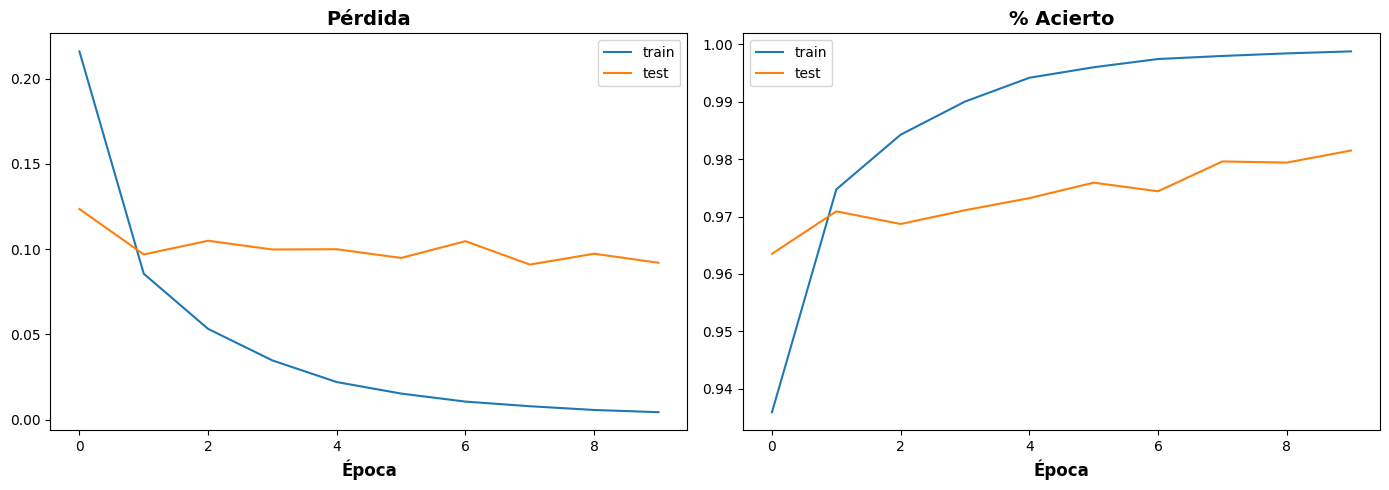

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Se hace el entrenamiento de la red neuronal base utilizando 10 epocas y sin aplicar agrupaciones (batch size) esto para evaluar el comportamiento del modelo con todas las entradas, sin aplicar segmentacion y realizando el entrenamiento estrictamente estocastico lo cual hara que nuestra red se ajuste utilizando una por una las muestras.

Como podemos observar en la epoca 5 el rendimiento tanto en training como en testing sigue aumentando sin haber una diferencia notable pero la perdida en la fase de testing empieza a aumentar quedando asi una diferencia algo notable en la epoca 10 en ambas perdidas.

Accuracy: 99.71% (Training) / 98.29% (testing) -> 1.42% de diferencia

Perdida: 0.0098 / 0.1143 -> 0.1045 diferencia de perdidas

Esto indica que el modelo base, al no presentar una diferencia notable entre el rendimiento durante el training y el testing se puede decir que esta generalizando de manera casi "perfecta", pese a esto se continuara con la experimentacion de distintos factores de la red neuronal para evaluar su comportamiento.

## Experimento 1: Aumento de batch Size

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8796 - loss: 0.4163 - val_accuracy: 0.9569 - val_loss: 0.1355
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9677 - loss: 0.1093 - val_accuracy: 0.9631 - val_loss: 0.1167
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9796 - loss: 0.0682 - val_accuracy: 0.9690 - val_loss: 0.0990
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9867 - loss: 0.0460 - val_accuracy: 0.9731 - val_loss: 0.0878
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9913 - loss: 0.0316 - val_accuracy: 0.9768 - val_loss: 0.0756
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9948 - loss: 0.0202 - val_accuracy: 0.9805 - val_loss: 0.0728
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9967 - loss: 0.0137 - val_accuracy: 0.9800 - val_loss: 0.0772
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9975 -

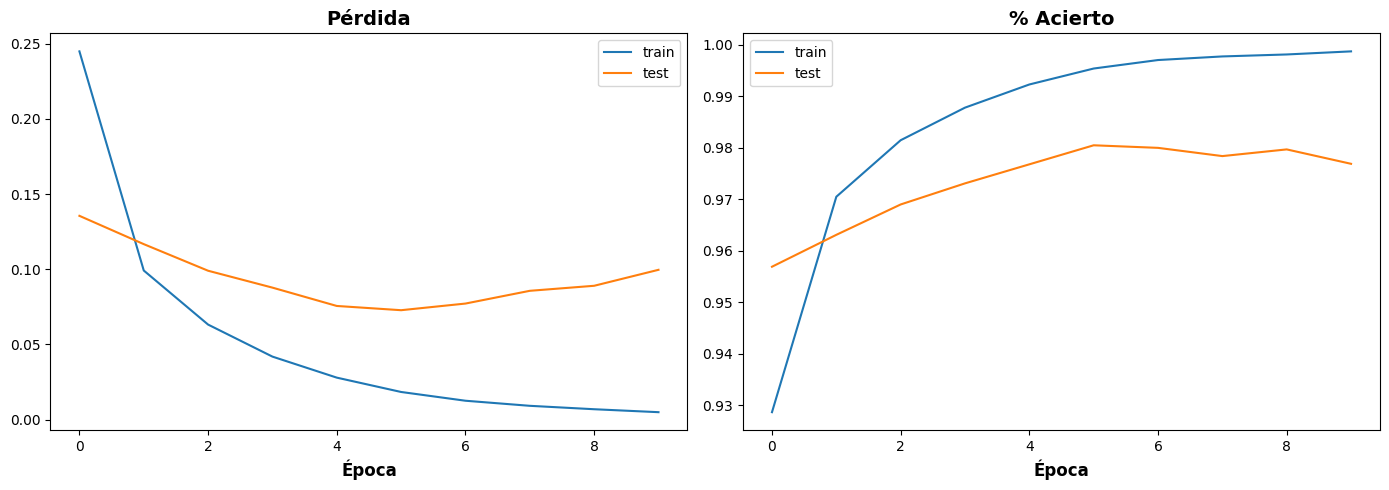

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("adamax_exp1", input_shape, labels_output, layers, "adamax")

history = train_model(history, model, X_train, y_train, X_test, y_test, 10, 32)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Se aumento el batch size a 10 para evitar que la red haga reajustes del peso con cada una de las muestras que recibe, esto permitira optimizar el tiempo de entrenamiento y poder suavizar el ruido que pueda presentar cada fase del entrenamiento por los mini ajustes que aplica.

A diferencia del entrenamiento base, en este caso ya en la epoca 3 se empieza a notar un aumento en la perdida y baja en la presicion del testing, se utilizara los resultados de la epoca 4 como evaluacion ya que es la ultima epoca en donde el modelo no empieza a perder rendimiento.

Accuracy: 99.97% (Training) / 98.42% (testing) -> 1.55% de diferencia

Perdida: 0.0011 / 0.1315 -> 0.1304 diferencia de perdidas

Como podemos ver el rendimiento del modelo, de nuestro primer experimento, se vio afectado negativamente ya que aumento ligeramente la diferencia tanto de perdida como de precision entre la fase de training y testing.

Aun asi, viendo que la diferencia no es tan alta se utilizara el batch size de 10 para los siguientes experimentos ya que al tener una muestra de datos balanceada y bien distribuida mitiga el ruido que puede generar cada muestra en el entrenamiento estocastico por lo que al aumentar el batch size se optimiza bastante el tiempo de ejecución.

## Experimento 2: Funcion de activacion Elu

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("adamax_exp2", input_shape, labels_output, layers, "adamax", "elu")

En este experimento se realizo una modificacion en la funcion de activacion de las capas ocultas, esto con el fin de evaluar si el rendimiento se ve afectado debido a que el calculo matematico que realiza la red en el entrenamiento (para calcular los pesos) esta dando 0 lo que indica que la neurona queda "muerta".

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - accuracy: 0.9001 - loss: 0.3275 - val_accuracy: 0.9574 - val_loss: 0.1405
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 58s 10ms/step - accuracy: 0.9660 - loss: 0.1085 - val_accuracy: 0.9676 - val_loss: 0.1065
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9774 - loss: 0.0721 - val_accuracy: 0.9682 - val_loss: 0.1031
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9839 - loss: 0.0529 - val_accuracy: 0.9698 - val_loss: 0.0985
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.9883 - loss: 0.0403 - val_accuracy: 0.9720 - val_loss: 0.0924
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - accuracy: 0.9921 - loss: 0.0302 - val_accuracy: 0.9739 - val_loss: 0.0889
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9941 - loss: 0.0226 - val_accuracy: 0.9745 - val_loss: 0.0927
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - accuracy: 0.9957 - loss

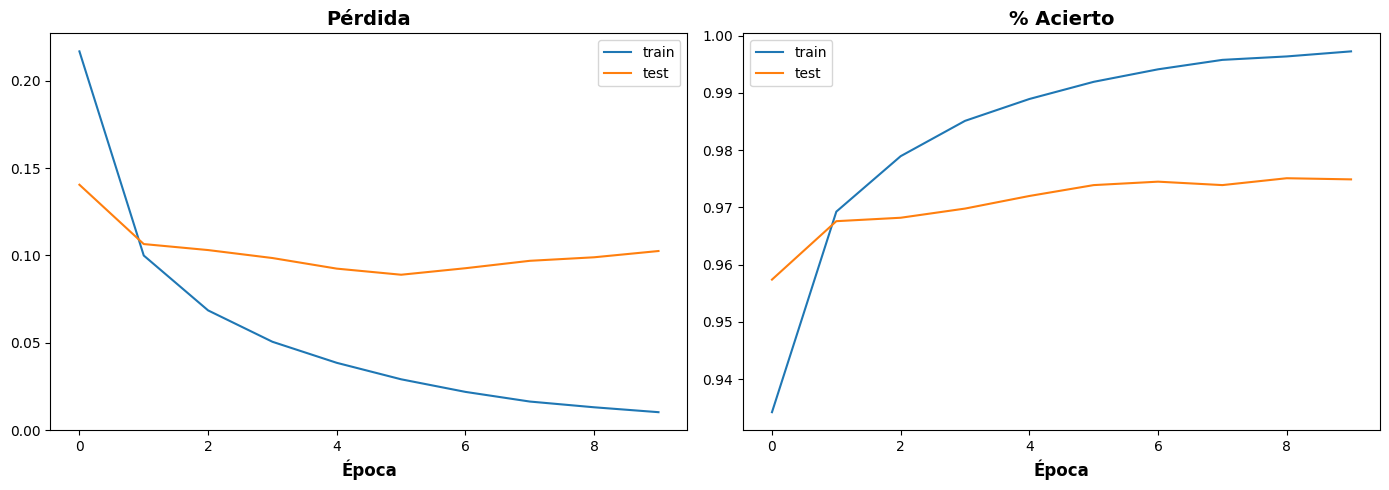

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Luego de aplicar el cambio en la funcion de activacion se puede observar fluctuaciones de perdida disparejas en cada epoca, en vez de ir aumentando o disminuyendo en cada epoca, va fluctuando hacia arriba y hacia abajo en cada una.

Accuracy: 99.55% (Training) / 97.95% (testing) -> 2% de diferencia

Perdida: 0.0098 / 0.1143 -> 0.0659 diferencia de perdidas

Tomando los resultados de la ultima epoca podemos observar que al aplicar el cambio en la funcion de activacion aumenta ligeramente la diferencia de precision entre la fase de training y testing, siendo esta de un 2% pero se disminuye considerablemente la diferencia de perdida entre ambas fases (Siendo mas relevante la disminucion de la perdida en la fase de testing).

## Experimento 3: Anexo de una capa oculta extra

In [ ]:
layers = np.array([512, 256, 128, 64, 32]) # agregamos una capa oculta de 32 neuronas
model = create_model("adamax_exp3", input_shape, labels_output, layers, "adamax", "elu")

En este experimento se anexo de una capa oculta lo que puede permitir el refinamiento del aprendizaje de la red neuronal ya que le permitira aprender patrones mas complejos al aplicar otra fase de procesamiento de datos.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.8974 - loss: 0.3351 - val_accuracy: 0.9578 - val_loss: 0.1403
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9649 - loss: 0.1138 - val_accuracy: 0.9639 - val_loss: 0.1180
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step - accuracy: 0.9769 - loss: 0.0757 - val_accuracy: 0.9664 - val_loss: 0.1089
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9840 - loss: 0.0562 - val_accuracy: 0.9673 - val_loss: 0.1068
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9876 - loss: 0.0426 - val_accuracy: 0.9686 - val_loss: 0.1042
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9909 - loss: 0.0324 - val_accuracy: 0.9703 - val_loss: 0.1022
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - accuracy: 0.9930 - loss: 0.0244 - val_accuracy: 0.9731 - val_loss: 0.1042
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.9947 - los

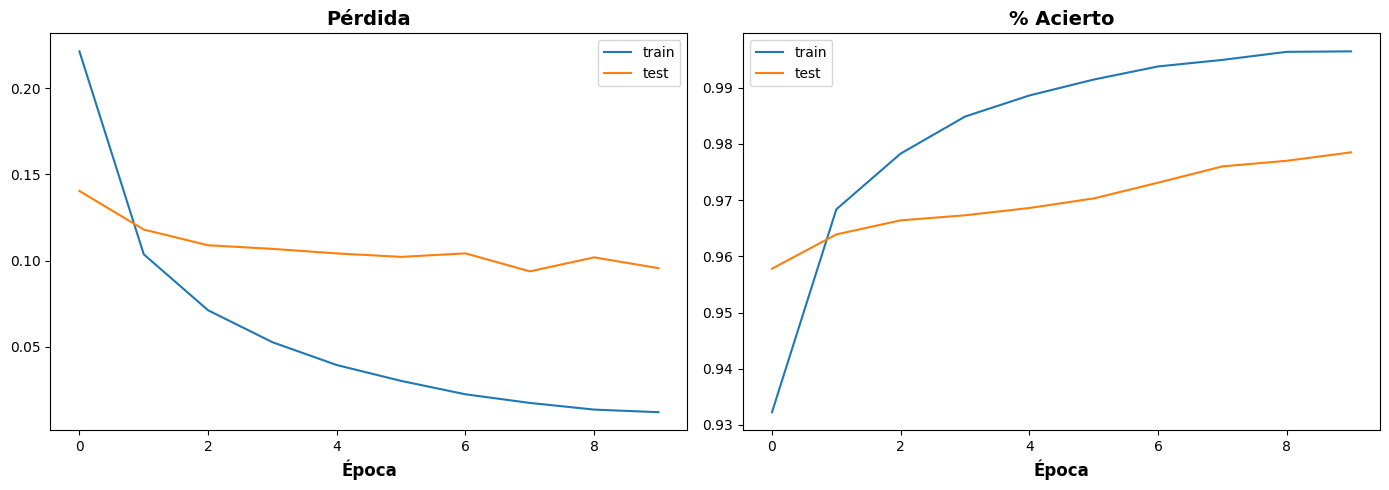

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Como se puede observar el rendimiento en la fase de testing, junto a su perdida, se vio afectado negativamente a partir de la epoca numero 8 por lo que se tomo la decision de realizar la evalucion de la red neuronal tomando las metricas de esa epoca.

Accuracy: 99.75% (Training) / 98.32% (testing) -> 1.43% de diferencia

Perdida: 0.0087 / 0.0641 -> 0.554 diferencia de perdidas

como podemos observar, al agregar una capa oculta a nuestra red neuronal y volviendo a utilizar la funcion de activacion **relu** se puede ver una mejoria en el rendimiento del modelo ya que no se sacrifica tanta precision como en experimentos anteriores pero se ve una diferencia y disminucion notable en la perdida de ambas fases (training & testing) esto puede deberse a que la red neuronal, con una capa oculta extra, esta identificando patrones mas complejos en nuestros datos lo que permite que entregue una respuesta mas acertada.

## Experimento 4: Aumento de neuronas

In [ ]:
layers = np.array([1024, 512, 256, 128]) # duplicamos las neuronas de las capas ocultas
model = create_model("adamax_exp4", input_shape, labels_output, layers, "adamax")

En este experimento se tomo la decision de duplicar las neuronas de cada una de las 4 capas ocultas, esto con el fin de poder entregar mas memoria a la red neuronal y permitira una mayor capacidad de analisis de cada uno de los datos que vienen en nuestra muestra.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 120s 20ms/step - accuracy: 0.8998 - loss: 0.3216 - val_accuracy: 0.9664 - val_loss: 0.1059
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 140s 19ms/step - accuracy: 0.9765 - loss: 0.0784 - val_accuracy: 0.9686 - val_loss: 0.1029
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 143s 20ms/step - accuracy: 0.9869 - loss: 0.0436 - val_accuracy: 0.9760 - val_loss: 0.0830
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 140s 19ms/step - accuracy: 0.9922 - loss: 0.0262 - val_accuracy: 0.9750 - val_loss: 0.0973
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 19ms/step - accuracy: 0.9952 - loss: 0.0162 - val_accuracy: 0.9790 - val_loss: 0.0872
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 144s 20ms/step - accuracy: 0.9968 - loss: 0.0103 - val_accuracy: 0.9780 - val_loss: 0.1011
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 116s 19ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9779 - val_loss: 0.1043
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 19ms/step - accuracy: 

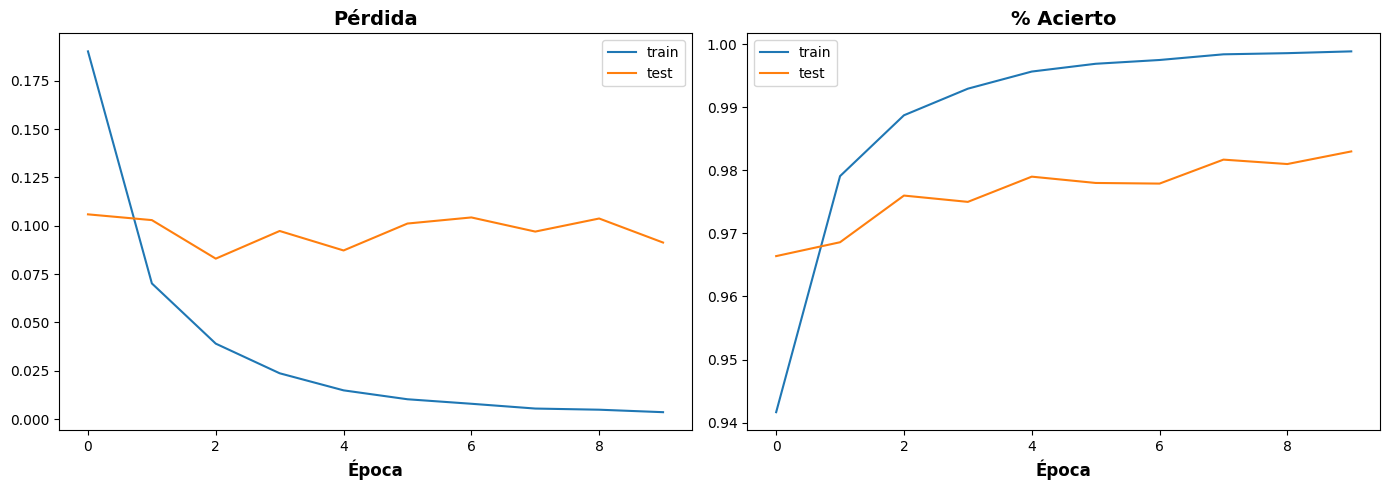

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

En este caso notamos que el rendimiento, como ocurrio en el experimento donde se aumentaron las capas ocultas, tiene fluctuaciones.

Accuracy: 99.92% (Training) / 98.38% (testing) -> 1.54% de diferencia

Perdida: 0.0036 / 0.0641 -> 0.0792 diferencia de perdidas

En este caso aumento la diferencia entre la precision de training & testing junto a la diferencia de perdida de ambas fases. Esto puede deberse al hecho de que la muestra que se esta utilizando no posee tanta variabilidad ni mucha complejidad en sus datos y el aumentar las neuronas solo ocasiono que aumente el rudio lo que puede influir negativamente en el rendimiento del modelo.

## Experimento 5: Apagado de neuronas

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas

model = create_model("adamax_exp5", input_shape, labels_output, layers, "adamax", dropout=np.array([2, 0.2]))

En este ultimo experimento se tomo la decision de aplicar un apagado del 20% de neuronas en la capa oculta 1 y 2 para ver como se comporta el modelo.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - accuracy: 0.8534 - loss: 0.4723 - val_accuracy: 0.9610 - val_loss: 0.1322
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9600 - loss: 0.1331 - val_accuracy: 0.9657 - val_loss: 0.1104
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - accuracy: 0.9718 - loss: 0.0938 - val_accuracy: 0.9760 - val_loss: 0.0836
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9780 - loss: 0.0720 - val_accuracy: 0.9769 - val_loss: 0.0790
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.9827 - loss: 0.0575 - val_accuracy: 0.9775 - val_loss: 0.0713
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9854 - loss: 0.0475 - val_accuracy: 0.9790 - val_loss: 0.0704
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9878 - loss: 0.0377 - val_accuracy: 0.9807 - val_loss: 0.0673
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.9898 - 

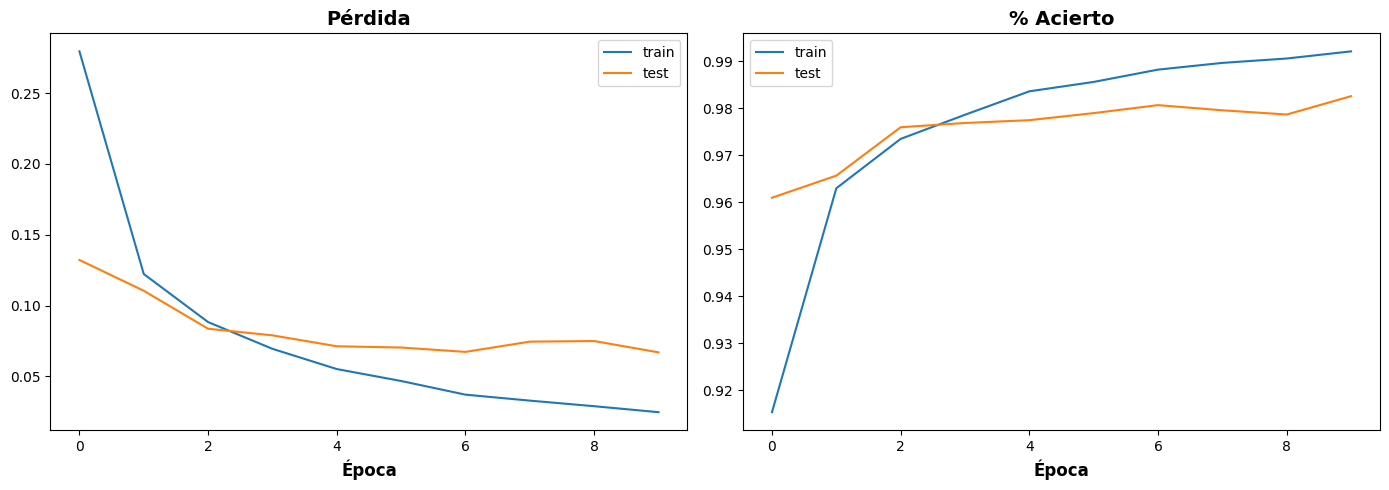

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

model.save(f"{model.name}.h5")

En este caso tambien se puede observar fluctuaciones en el rendimiento de ambas fases, donde a partir de la epoca 4 en rendimiento empieza a decaer por ende utilizaremos esta epoca para la evaluacion.

Accuracy: 99.96% (Training) / 98.48% (testing) -> 1.48% de diferencia

Perdida: 0.0011 / 0.1016 -> 0.1005 diferencia de perdidas

como se puede observar el rendimiento general del modelo se vio afectado negativamente, esto puede ser debido a que al aplicarse a capas tempranas se elimina informacion importante que estas pueden entregar a las capas sub-siguientes ademas el la tecnica de dropout es ideal para eviar el sobreajuste, lo cual no se observa en esta muestra de datos ya que no hay una diferencia notoria en la fase de training y testing.

# Red neuronal 2: Optimizador Nadam

## Red base

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("nadam_base", input_shape, labels_output, layers, "nadam")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9017 - loss: 0.3239 - val_accuracy: 0.9644 - val_loss: 0.1239
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9675 - loss: 0.1133 - val_accuracy: 0.9713 - val_loss: 0.1086
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9768 - loss: 0.0813 - val_accuracy: 0.9703 - val_loss: 0.1113
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9817 - loss: 0.0639 - val_accuracy: 0.9738 - val_loss: 0.1120
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9835 - loss: 0.0570 - val_accuracy: 0.9711 - val_loss: 0.1413
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9858 - loss: 0.0496 - val_accuracy: 0.9787 - val_loss: 0.0951
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.9871 - loss: 0.0452 - val_accuracy: 0.9744 - val_loss: 0.1108
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - accuracy: 0.9898 -

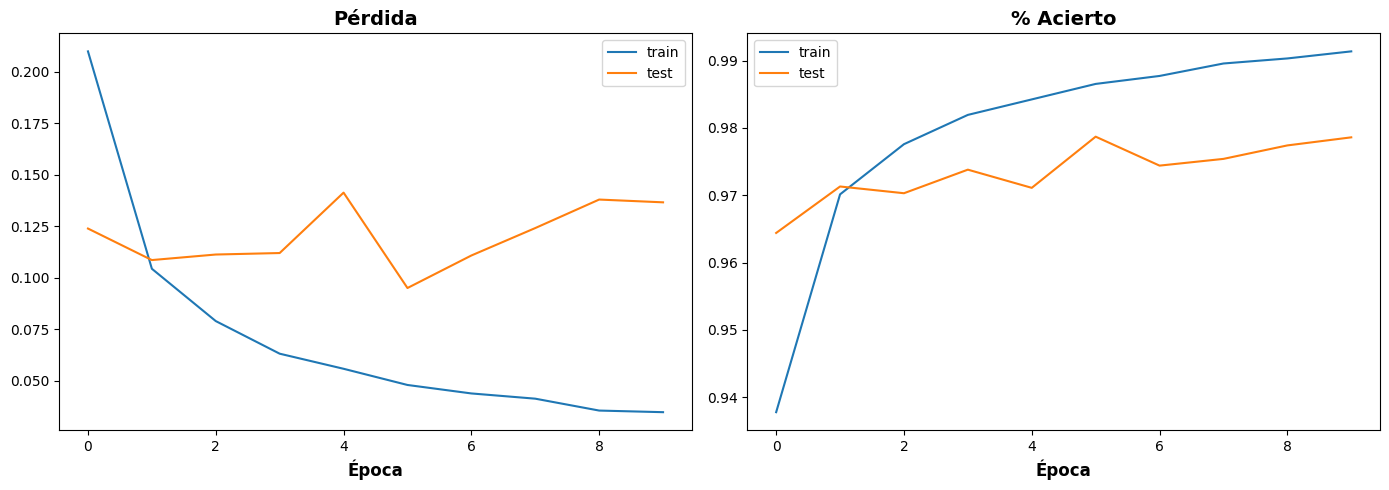

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


En este caso se tomo la decision de utilizar unicamente la precisión (accuracy) ya que es la metrica mas relevente para la problematica presentada. El f1-score solo nos sera util si hay presente desbalance de clase y este no es el caso (informacion entregada por el negocio - docente).

La precision y el recall, su interpretacion, habla sobre clase positiva y clase negativa haciendo alucion a un modelo de prediccion binario, es decir que solo tiene 2 clases. En este caso nuestro modelo es multi-clase por lo que estas metricas pierden total relevancia dado el enfoque de nuestro modelo.

##Experimento 1: Aumento de batch Size

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.8995 - loss: 0.3329 - val_accuracy: 0.9608 - val_loss: 0.1251
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9703 - loss: 0.0979 - val_accuracy: 0.9647 - val_loss: 0.1179
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9792 - loss: 0.0658 - val_accuracy: 0.9723 - val_loss: 0.1066
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9856 - loss: 0.0487 - val_accuracy: 0.9678 - val_loss: 0.1401
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9864 - loss: 0.0445 - val_accuracy: 0.9777 - val_loss: 0.0963
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9895 - loss: 0.0343 - val_accuracy: 0.9725 - val_loss: 0.1371
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9898 - loss: 0.0329 - val_accuracy: 0.9803 - val_loss: 0.0846
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.9927 -

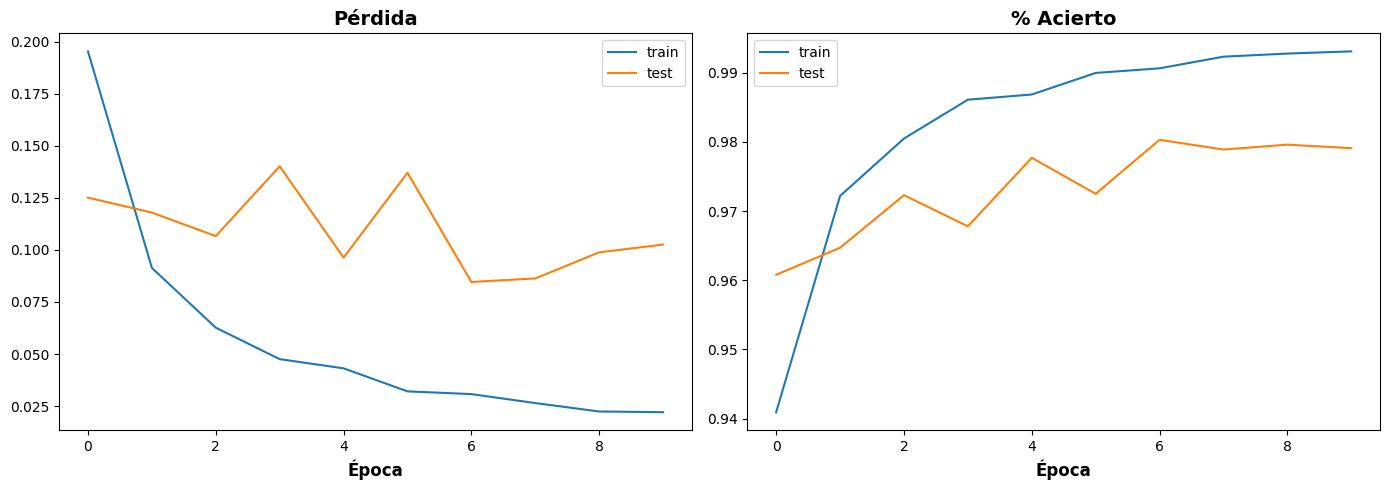

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("nadam_exp1", input_shape, labels_output, layers, "nadam")

history = train_model(history, model, X_train, y_train, X_test, y_test, 10, 32)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


Se aumento el batch size a 10 para evitar que la red haga reajustes del peso con cada una de las muestras que recibe, esto permitira optimizar el tiempo de entrenamiento y poder suavizar el ruido que pueda presentar cada fase del entrenamiento por los mini ajustes que aplica.

A diferencia del entrenamiento base, en este caso podemos apreciar que la pérdida disminuye de forma constante y progresiva, lo que indica un mejor rendimiento al aumentar el batch size.

Accuracy: 99.18% (Training) / 98.26% (testing) -> 0.92% de diferencia

Perdida: 0.0306 / 0.0972 -> 0.0666 diferencia de perdidas

Gracias a los datos observados, se aprecia una mejora en el rendimiento general tanto en testing como en training, por lo que se continuará con un batch size de 10.

##Experimento 2: Funcion de activacion Elu

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("nadam_exp2", input_shape, labels_output, layers, "nadam", "elu")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.8897 - loss: 0.3594 - val_accuracy: 0.9551 - val_loss: 0.1495
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9556 - loss: 0.1485 - val_accuracy: 0.9605 - val_loss: 0.1379
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9686 - loss: 0.1056 - val_accuracy: 0.9683 - val_loss: 0.1149
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.9760 - loss: 0.0840 - val_accuracy: 0.9703 - val_loss: 0.1220
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9787 - loss: 0.0826 - val_accuracy: 0.9651 - val_loss: 0.1366
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.9827 - loss: 0.0609 - val_accuracy: 0.9698 - val_loss: 0.1409
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9838 - loss: 0.0623 - val_accuracy: 0.9735 - val_loss: 0.1170
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.9863 -

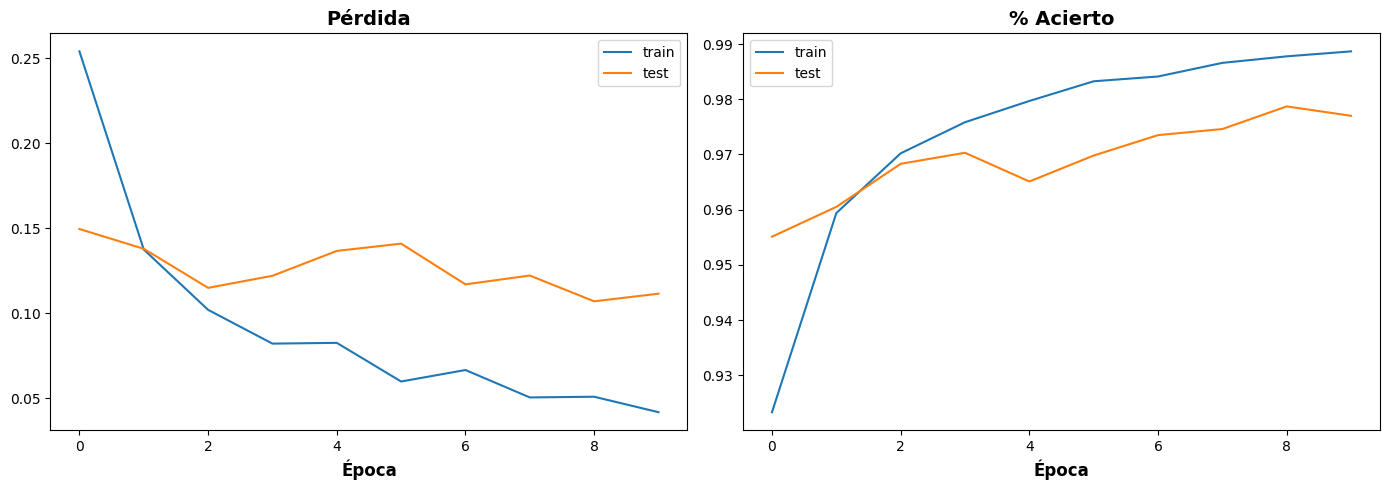

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()



En este experimento se realizo una modificacion en la funcion de activacion de las capas ocultas, esto con el fin de evaluar si el rendimiento se ve afectado debido a que el calculo matematico que realiza la red en el entrenamiento (para calcular los pesos) esta dando 0 lo que indica que la neurona queda "muerta".

##Experimento 3: Anexo de una capa oculta extra

In [ ]:
layers = np.array([512, 256, 128, 64, 32]) # agregamos una capa oculta de 32 neuronas
model = create_model("nadam_exp3", input_shape, labels_output, layers, "nadam", "elu")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - accuracy: 0.8843 - loss: 0.3725 - val_accuracy: 0.9492 - val_loss: 0.1786
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9535 - loss: 0.1579 - val_accuracy: 0.9626 - val_loss: 0.1384
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9674 - loss: 0.1138 - val_accuracy: 0.9639 - val_loss: 0.1316
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9734 - loss: 0.0921 - val_accuracy: 0.9707 - val_loss: 0.1191
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9797 - loss: 0.0726 - val_accuracy: 0.9641 - val_loss: 0.1448
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9828 - loss: 0.0585 - val_accuracy: 0.9628 - val_loss: 0.1618
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9839 - loss: 0.0591 - val_accuracy: 0.9754 - val_loss: 0.1085
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9861 -

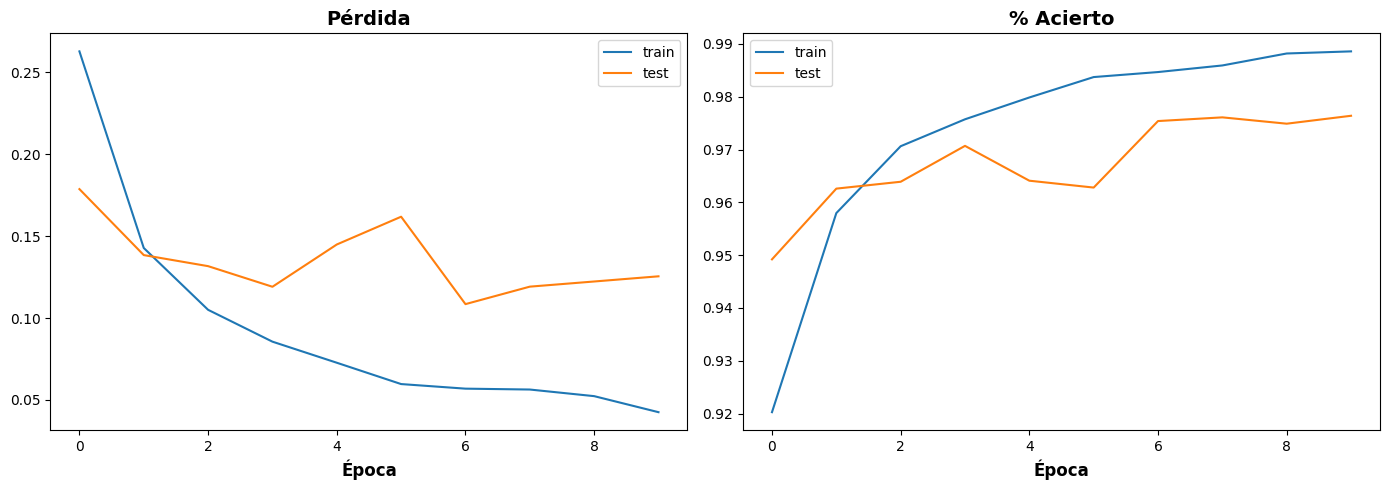

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


En este experimento se anexo de una capa oculta lo que puede permitir el refinamiento del aprendizaje de la red neuronal ya que le permitira aprender patrones mas complejos al aplicar otra fase de procesamiento de datos.

##Experimento 4: Aumento de neuronas

In [ ]:
layers = np.array([1024, 512, 256, 128]) # duplicamos las neuronas de las capas ocultas
model = create_model("nadam_exp4", input_shape, labels_output, layers, "nadam")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 139s 23ms/step - accuracy: 0.8995 - loss: 0.3312 - val_accuracy: 0.9632 - val_loss: 0.1254
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 137s 23ms/step - accuracy: 0.9661 - loss: 0.1258 - val_accuracy: 0.9718 - val_loss: 0.1119
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - accuracy: 0.9758 - loss: 0.0900 - val_accuracy: 0.9722 - val_loss: 0.1104
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - accuracy: 0.9811 - loss: 0.0714 - val_accuracy: 0.9702 - val_loss: 0.1363
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - accuracy: 0.9830 - loss: 0.0665 - val_accuracy: 0.9753 - val_loss: 0.1193
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - accuracy: 0.9855 - loss: 0.0579 - val_accuracy: 0.9744 - val_loss: 0.1220
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 149s 25ms/step - accuracy: 0.9876 - loss: 0.0476 - val_accuracy: 0.9683 - val_loss: 0.1975
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 139s 23ms/step - accuracy: 

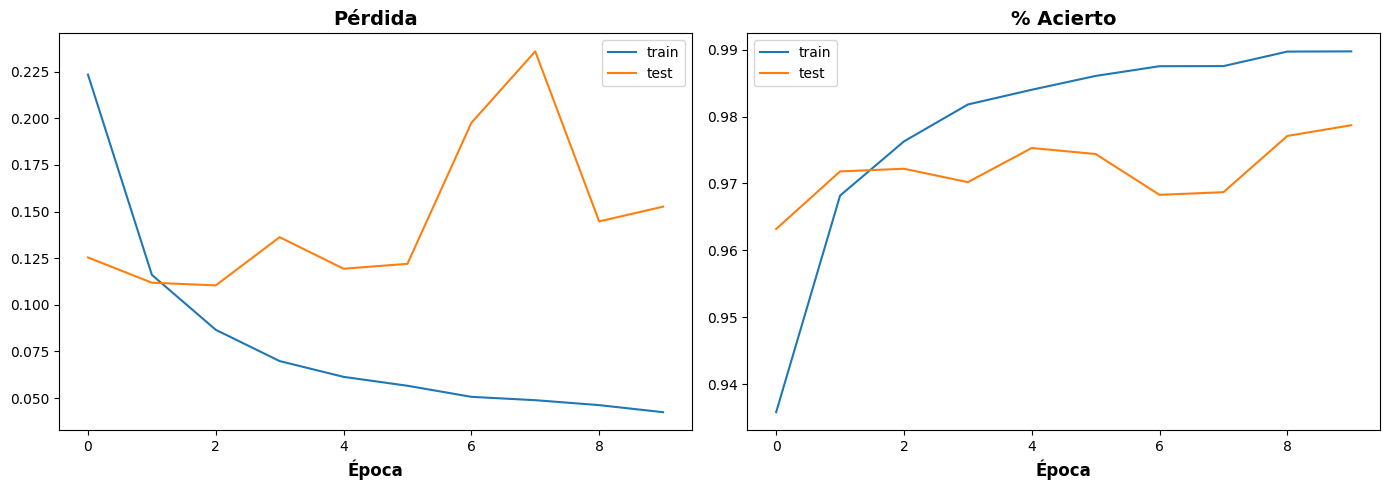

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


En este experimento se tomo la decision de duplicar las neuronas de cada una de las 4 capas ocultas, esto con el fin de poder entregar mas memoria a la red neuronal y permitira una mayor capacidad de analisis de cada uno de los datos que vienen en nuestra muestra.

##Experimento 5: Apagado de neuronas

In [ ]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas

model = create_model("nadam_exp5", input_shape, labels_output, layers, "nadam", dropout=np.array([2, 0.2]))

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.8793 - loss: 0.3881 - val_accuracy: 0.9563 - val_loss: 0.1491
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9575 - loss: 0.1470 - val_accuracy: 0.9700 - val_loss: 0.1105
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9679 - loss: 0.1178 - val_accuracy: 0.9710 - val_loss: 0.1045
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9729 - loss: 0.0965 - val_accuracy: 0.9745 - val_loss: 0.0987
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9768 - loss: 0.0827 - val_accuracy: 0.9734 - val_loss: 0.1019
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9783 - loss: 0.0763 - val_accuracy: 0.9771 - val_loss: 0.1011
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9809 - loss: 0.0722 - val_accuracy: 0.9775 - val_loss: 0.1001
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.9817 -

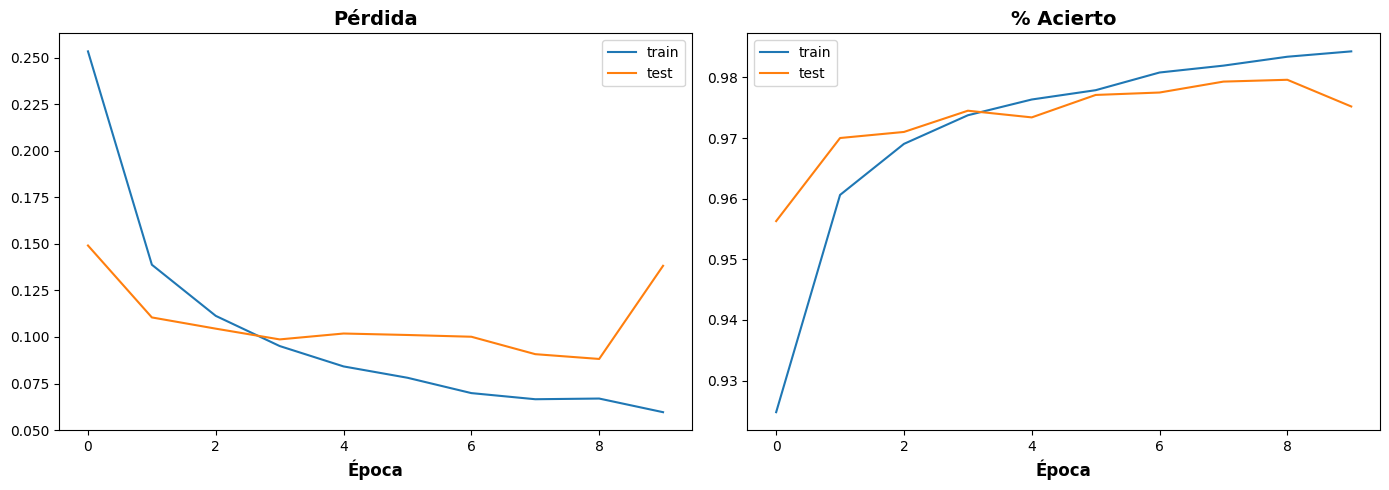

In [ ]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


En este ultimo experimento se tomo la decision de aplicar un apagado del 20% de neuronas en la capa oculta 1 y 2 para ver como se comporta el modelo.

#Evaluación

El modelo seleccionado como el mejor calificado entre todos los evaluados es la Red Neuronal 1 del Experimento 5. Aunque todos los modelos presentan un accuracy similar, este modelo destaca por presentar la menor función de pérdida tanto en el conjunto de entrenamiento como en el de prueba, lo que indica una mejor capacidad de generalización y un menor sobreajuste (overfitting).